### Environment Config

In [6]:
import numpy as np
import pandas as pd
from IPython.display import display
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import requests
from zipfile import ZipFile
import io
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 500)

### Download GloVe Word Embeddings
[GloVe](https://nlp.stanford.edu/projects/glove/) word embeddings are vector representation of words. These word embeddings will be used to create vectors for our sentences. We could have also used the Bag-of-Words or TF-IDF approaches to create features for our sentences, but these methods ignore the order of the words (and the number of features is usually pretty large).

We will be using the pre-trained Wikipedia 2014 + Gigaword 5 GloVe vectors available [here](https://nlp.stanford.edu/data/glove.6B.zip). Heads up – the size of these word embeddings is 822 MB.

In [ ]:
url = 'http://nlp.stanford.edu/data/glove.6B.zip'
file_zipped = requests.get(url, allow_redirects=True)
z = ZipFile(io.BytesIO(file_zipped.content))
z.extractall('.')

#### Extract the words embeddings or word vectors.

In [ ]:
# Extract word vectors
word_embeddings = {}
f = open('glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    word_embeddings[word] = coefs
f.close()

len(word_embeddings)

400000

We have word vectors for 400,000 different terms stored in the dictionary – ‘word_embeddings’.

### Read Dataset

Data was preprocessed by other script available in: https://github.com/HWatanuki/Projeto_D3TOP/blob/main/Codigos/Data_preprocessing_v0.2.ipynb

In [9]:
file_path = '../Datasets/processed/'
file_name = 'dataset_airbnb-processed-spacy_2023-04-13_03-28-09-439.csv'

df = pd.read_csv(file_path + file_name, dtype=str)
print(f'No Rows: {df.shape[0]}')
print(f'No Columns: {df.shape[1]}', end='\n\n')
display(df.head())

No Rows: 561
No Columns: 94



,address,isAvailable,isHostedBySuperhost,location/lat,location/lng,numberOfGuests,photos/0/caption,photos/0/pictureUrl,photos/0/thumbnailUrl,pricing/rate/amount,pricing/rate/amountFormatted,pricing/rate/currency,pricing/rate/isMicrosAccuracy,pricing/rateType,primaryHost/badges/0,primaryHost/badges/1,primaryHost/badges/2,primaryHost/firstName,primaryHost/hasInclusionBadge,primaryHost/hasProfilePic,primaryHost/id,primaryHost/isSuperHost,primaryHost/languages/0,primaryHost/listingsCount,primaryHost/memberSince,primaryHost/responseRate,primaryHost/responseTime,primaryHost/smartName,primaryHost/totalListingsCount,reviews/0/author/firstName,reviews/0/author/id,reviews/0/createdAt,reviews/0/id,reviews/0/rating,reviews/1/author/firstName,reviews/1/author/id,reviews/1/createdAt,reviews/1/id,reviews/1/rating,reviews/2/author/firstName,reviews/2/author/id,reviews/2/createdAt,reviews/2/id,reviews/2/rating,reviews/3/author/firstName,reviews/3/author/id,reviews/3/createdAt,reviews/3/id,reviews/3/rating,reviews/4/author/firstName,reviews/4/author/id,reviews/4/createdAt,reviews/4/id,reviews/4/rating,reviews/5/author/firstName,reviews/5/author/id,reviews/5/createdAt,reviews/5/id,reviews/5/rating,reviews/6/author/firstName,reviews/6/author/id,reviews/6/createdAt,reviews/6/id,reviews/6/rating,reviews/7/author/firstName,reviews/7/author/id,reviews/7/createdAt,reviews/7/id,reviews/7/rating,reviews/8/author/firstName,reviews/8/author/id,reviews/8/createdAt,reviews/8/id,reviews/8/rating,reviews/9/author/firstName,reviews/9/author/id,reviews/9/createdAt,reviews/9/id,reviews/9/rating,roomType,stars,url,name,primaryHost/about,reviews/0/comments,reviews/1/comments,reviews/2/comments,reviews/3/comments,reviews/4/comments,reviews/5/comments,reviews/6/comments,reviews/7/comments,reviews/8/comments,reviews/9/comments
0,"Jersey City, New Jersey, United States",true,false,40.7233,-74.03946,2,NaN,https://a0.muscache.com/im/pictures/miso/Hosting-53775685/original/0812b9a1-2d2e-4725-b51f-881045a939b2.jpeg?aki_policy=large,https://a0.muscache.com/im/pictures/miso/Hosting-53775685/original/0812b9a1-2d2e-4725-b51f-881045a939b2.jpeg?aki_policy=small,99999,"$99,999",USD,false,nightly,82 Reviews,Identity verified,NaN,Joes,false,true,245395267,false,中文 (简体),8,Joined in February 2019,NaN,NaN,Joes,14,Miranda,74889676.0,2022-06-20T19:58:54Z,6.536263641559459e+17,4,Abhimanyu,4800160.0,2022-05-23T18:57:26Z,6.333017075212511e+17,5,Robert,162871850.0,2022-05-06T17:28:10Z,6.209355874005248e+17,5,Yu,303996502.0,2022-01-09T21:55:09Z,5.362712073993113e+17,5,Mitesh,253080011.0,2021-12-26T20:27:02Z,5.260799932553211e+17,4.0,Arusha,103758126.0,2021-12-22T21:29:10Z,5.2321216515417446e+17,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Entire rental unit,4.67,https://www.airbnb.com/rooms/53775685,entire cozy unit mins manhattan,hello welcome love see world able help people feel right home,great location nice building love parking include,stay perfect mention listing location min walk newport path right opposite huge grocery store joes super kind early checkin late checkout,excellent place stay central fo travel nyc work travel new jersey stay months apartment place advertise joes excellent host,best airbnb stay get great view outside window comfortable convenient living experience settle great,nice apartment great locality apartment list definitely rate star airbnb pet hair carpet couch month old bit concerned have allergies look clean place joes approachable easy communicate,customer take chance trust listing apartment exceed expectations super clean aesthetically pleasing minimalistic vibe definitely luxury apartment building convenient location right shoprite near waterfront path host responsive questions thanks great stay,NaN,NaN,NaN,NaN
1,"New York, United States",true,false,40.70641,-74.0092,2,NaN,https://a0.muscache.com/im/pictures/e2388507-1f5f-4000-aa1b-d3b2279e682a.jpg?aki_policy=large,https://a0.muscache.com/im/pictures/e2388507-1f5f-4000

### Manipulating data for vector representation

In [ ]:
# Join all reviews comments for each announcement record
df_s01 = df.copy()
df_s01['comments'] = df_s01[df_s01.columns[df_s01.columns.str.contains('comments')]].agg(lambda x: ' '.join([str(c) for c in x.values if str(c) != 'nan']), axis=1).T
df_s01.head()

,address,isAvailable,isHostedBySuperhost,location/lat,location/lng,numberOfGuests,photos/0/caption,photos/0/pictureUrl,photos/0/thumbnailUrl,pricing/rate/amount,pricing/rate/amountFormatted,pricing/rate/currency,pricing/rate/isMicrosAccuracy,pricing/rateType,primaryHost/badges/0,primaryHost/badges/1,primaryHost/badges/2,primaryHost/firstName,primaryHost/hasInclusionBadge,primaryHost/hasProfilePic,primaryHost/id,primaryHost/isSuperHost,primaryHost/languages/0,primaryHost/listingsCount,primaryHost/memberSince,primaryHost/responseRate,primaryHost/responseTime,primaryHost/smartName,primaryHost/totalListingsCount,reviews/0/author/firstName,reviews/0/author/id,reviews/0/createdAt,reviews/0/id,reviews/0/rating,reviews/1/author/firstName,reviews/1/author/id,reviews/1/createdAt,reviews/1/id,reviews/1/rating,reviews/2/author/firstName,reviews/2/author/id,reviews/2/createdAt,reviews/2/id,reviews/2/rating,reviews/3/author/firstName,reviews/3/author/id,reviews/3/createdAt,reviews/3/id,reviews/3/rating,reviews/4/author/firstName,reviews/4/author/id,reviews/4/createdAt,reviews/4/id,reviews/4/rating,reviews/5/author/firstName,reviews/5/author/id,reviews/5/createdAt,reviews/5/id,reviews/5/rating,reviews/6/author/firstName,reviews/6/author/id,reviews/6/createdAt,reviews/6/id,reviews/6/rating,reviews/7/author/firstName,reviews/7/author/id,reviews/7/createdAt,reviews/7/id,reviews/7/rating,reviews/8/author/firstName,reviews/8/author/id,reviews/8/createdAt,reviews/8/id,reviews/8/rating,reviews/9/author/firstName,reviews/9/author/id,reviews/9/createdAt,reviews/9/id,reviews/9/rating,roomType,stars,url,name,primaryHost/about,reviews/0/comments,reviews/1/comments,reviews/2/comments,reviews/3/comments,reviews/4/comments,reviews/5/comments,reviews/6/comments,reviews/7/comments,reviews/8/comments,reviews/9/comments,comments
0,"Jersey City, New Jersey, United States",true,false,40.7233,-74.03946,2,NaN,https://a0.muscache.com/im/pictures/miso/Hosting-53775685/original/0812b9a1-2d2e-4725-b51f-881045a939b2.jpeg?aki_policy=large,https://a0.muscache.com/im/pictures/miso/Hosting-53775685/original/0812b9a1-2d2e-4725-b51f-881045a939b2.jpeg?aki_policy=small,99999,"$99,999",USD,false,nightly,82 Reviews,Identity verified,NaN,Joes,false,true,245395267,false,中文 (简体),8,Joined in February 2019,NaN,NaN,Joes,14,Miranda,74889676.0,2022-06-20T19:58:54Z,6.536263641559459e+17,4,Abhimanyu,4800160.0,2022-05-23T18:57:26Z,6.333017075212511e+17,5,Robert,162871850.0,2022-05-06T17:28:10Z,6.209355874005248e+17,5,Yu,303996502.0,2022-01-09T21:55:09Z,5.362712073993113e+17,5,Mitesh,253080011.0,2021-12-26T20:27:02Z,5.260799932553211e+17,4.0,Arusha,103758126.0,2021-12-22T21:29:10Z,5.2321216515417446e+17,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Entire rental unit,4.67,https://www.airbnb.com/rooms/53775685,entire cozy unit mins manhattan,love people feel,great location nice building love parking include,stay perfect mention listing location min walk newport path huge grocery store joes super kind early checkin late checkout,excellent place stay central fo travel nyc work travel jersey stay months apartment place advertise joes excellent host,airbnb stay great view window comfortable convenient living experience settle great,nice apartment great locality apartment list rate star airbnb pet hair carpet couch month bit concerned allergies clean place joes approachable easy communicate,customer chance trust listing apartment exceed expectations super clean aesthetically pleasing minimalistic vibe luxury apartment building convenient location shoprite waterfront path host responsive questions great stay,NaN,NaN,NaN,NaN,great location nice building love parking include stay perfect mention listing location min walk newport path huge grocery store joes super kind early checkin late checkout excellent place stay central fo travel nyc work travel jersey stay months apartment place advertise joes excellent host airbnb stay great view window comfortable conveni

In [ ]:
# Select just some interesting columns
df_s02 = df_s01[['address', 'numberOfGuests', 'name', 'pricing/rate/amount', 'roomType', 'comments']].copy()
df_s02

,address,numberOfGuests,name,pricing/rate/amount,roomType,comments
0,"Jersey City, New Jersey, United States",2,entire cozy unit mins manhattan,99999,Entire rental unit,great location nice building love parking include stay perfect mention listing location min walk newport path huge grocery store joes super kind early checkin late checkout excellent place stay central fo travel nyc work travel jersey stay months apartment place advertise joes excellent host airbnb stay great view window comfortable convenient living experience settle great nice apartment great locality apartment list rate star airbnb pet hair carpet couch month bit concerned allergies clean place joes approachable easy communicate customer chance trust listing apartment exceed expectations super clean aesthetically pleasing minimalistic vibe luxury apartment building convenient location shoprite waterfront path host responsive questions great stay
1,"New York, United States",2,lux studio wall street heart fidi,10000,Entire rental unit,place perfect month stay clean organize location convenient close supermarket pharmacy restaurants chris wonderful host extremely attentive easy communicate book
2,"New York, United States",12,studio double queen refinery hotel,1639,Entire serviced apartment,
3,"East Orange, New Jersey, United States",16,nyc filming weddings retreat,1801,Entire condo,
4,"Passaic, New Jersey, United States",16,artists loaf,2500,Entire loft,
...,...,...,...,...,...,...
556,"New York, United States",4,midtown br elevator doorman nr,399,Entire rental unit,
557,"New York, United States",2,king bed suite central park,391,Room in hotel,great place stay great night stay location great room clean perfect enjoy place good place stay great location
558,"New York, United States",4,sutton place br gym pool dm nr central pk,431,Entire rental unit,
559,"New York, United States",4,sunny east village loft,419,Entire loft,great place great location great host peaceful comfortable colorful fun phillip recommendations perfect notice local places point true feel neighborhood daughter neighborhood let enjoy gem place phillip wonderful host super responsive document extremely helpful check explore area apartment charming wonderful location absolutely love interior design decorations love stay amazing apartment guest location great iron city york ventilation improve cook share amazing place feel yorker extremely clean fun decor loft pull bed comfortable comfortable place great location place clean host extremely communicative stay great location address list actual airbnb listing booking document philip send separately apartment floor nice advance case disability older guests clean neat cleaning crew prior stay forget remove food previous guests refrigerator philip wonderful host terrific communicator place fabulous layout decor super comfy sofa bed stay terrace perfect stay philip lot thought create space location incredible surely stay future fantastic nyc apartment large balcony overlook street noisy plenty natural light great location phillip include plenty recommendation feel locals great location good bed tasteful apartment busy area quiet place peaceful getaway manhattan philipp commit host need


### Vector Representation of Sentences in columns `comments`

In [ ]:
comment_id = 496
sentences = df_s02['comments'].iloc[comment_id].split('  ')
sentence_vectors = []
for i in sentences:
  if len(i) != 0:
    v = sum([word_embeddings.get(w, np.zeros((100,))) for w in i.split()])/(len(i.split())+0.001)
  else:
    v = np.zeros((100,))
  sentence_vectors.append(v)

In [ ]:
sentence_vectors[:3]

[array([ 0.02246014,  0.24159975,  0.15256001,  0.02144441,  0.04893422,
         0.23178481, -0.28749731,  0.36314405, -0.05309126, -0.01124537,
         0.04791138, -0.12440256,  0.15622345, -0.08932914,  0.05461508,
        -0.14577179,  0.0278677 ,  0.10546105, -0.34166412,  0.23018181,
         0.20796672,  0.26798329,  0.01145381, -0.44279503, -0.04440032,
        -0.10157296, -0.07124487, -0.28275017, -0.17414896, -0.07819327,
        -0.2157473 ,  0.21340543,  0.05415697,  0.09780058,  0.28471932,
         0.42168791, -0.0607991 ,  0.09958948,  0.10631166, -0.2155577 ,
         0.17845829, -0.22564328,  0.11485067, -0.33021403,  0.23046004,
         0.17049463,  0.02369283, -0.02503518,  0.29621516, -0.39558476,
        -0.02091952, -0.13666123, -0.03067406,  0.54872555, -0.09488213,
        -1.72448597,  0.08875228,  0.0130519 ,  1.1552471 ,  0.02802703,
        -0.33863858,  0.50581928, -0.08482098, -0.03036119,  0.48188841,
         0.02198915,  0.29582999, -0.07433586,  0.1

### Similarity Matrix Preparation

using the cosine similarity approach

In [ ]:
# similarity matrix
sim_mat = np.zeros([len(sentences), len(sentences)])

In [ ]:
# initialize the matrix with cosine similarity scores.

for i in range(len(sentences)):
  for j in range(len(sentences)):
    if i != j:
      sim_mat[i][j] = cosine_similarity(sentence_vectors[i].reshape(1,100), sentence_vectors[j].reshape(1,100))[0,0]

convert the similarity matrix `sim_mat` into a graph. The nodes of this graph will represent the sentences and the edges will represent the similarity scores between the sentences. 

In [ ]:
nx_graph = nx.from_numpy_array(sim_mat)
scores = nx.pagerank(nx_graph)

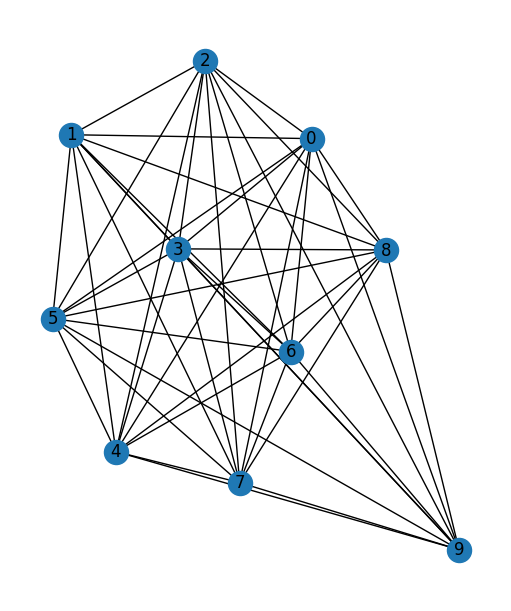

In [ ]:
fig, ax = plt.subplots(figsize=(5,6), layout='constrained')
nx.draw(nx_graph, with_labels=True)
plt.show()

### Summary Extraction

In [ ]:
ranked_sentences = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)

In [ ]:
# Extract top 10 sentences as the summary
n_range = 5 if len(sentences) >= 5 else 2
for i in range(n_range):
  print(ranked_sentences[i][1])

great stay superb location central subway access nyc offer lots great restaurants coffee shops walking distance quiet safe area apartment homey comfortable amenities need rozaliya fantastic host responsive recommend place love stay nyc
terms location rozaliyas flat grand central minutes walk rockefeller center choice restaurants breakfast places contact super friendly helpful amenities flat great comfy couch sleep comfy bed big tvs dining table complain noise level york noisy windows sound european standards nights short earplugs quiet evening happy central location explore manhattan moneys worth
perfect stay rozaliya appartement warm quality bed lot space cook close shops buy food good location nyc nyc rozaliya apartment
amazing time alex rozaliya place apartment spacious clean need month stay comfiest couch huge tvs fully equip kitchen locate blocks grand central alex rozaliya responsive questions stay open recommend
perfect apartment great location blocks clean comfortable


In [ ]:
sentences[:10]

['great stay superb location central subway access nyc offer lots great restaurants coffee shops walking distance quiet safe area apartment homey comfortable amenities need rozaliya fantastic host responsive recommend place love stay nyc',
 'experience airbnb rozaliya family nice welcoming set arrival recommend',
 'terrific stay great location plenty space rozaliya helpful accommodating',
 'terms location rozaliyas flat grand central minutes walk rockefeller center choice restaurants breakfast places contact super friendly helpful amenities flat great comfy couch sleep comfy bed big tvs dining table complain noise level york noisy windows sound european standards nights short earplugs quiet evening happy central location explore manhattan moneys worth',
 'rozaliyas apartment lovely spacious wellequipped need kitchenware towels tv internet blow dryer bed couch soft comfortable apartment prewar building locate centrally nyc access grocery stores subway restaurants deli pharmacy rozaliya 



---



---

## Outra tentativa

---


In [5]:
# Join all reviews comments for each announcement record
df_s01 = df.copy()
df_s01['comments'] = df_s01[df_s01.columns[df_s01.columns.str.contains('comments')]].agg(lambda x: ' '.join([str(c) for c in x.values if str(c) != 'nan']), axis=1).T

In [25]:
df_s02 = df_s01[['address', 'numberOfGuests', 'name', 'pricing/rate/amount', 'roomType', 'stars',  'comments']].copy()
df_s02.sample(1)

,address,numberOfGuests,name,pricing/rate/amount,roomType,stars,comments
381,"New York, United States",7,uws br bth apt block central park,525,Entire rental unit,5.0,jamie place amazing stay weeks enjoy day location ideal quiet upper west street equally accessible stations abc central park short journey great place spend afternoon apartment hosts friendly easy communicate super gracious supplement supplies multiple amazon fresh deliveries plenty room spread comfortable floor townhouse great location convenient park foods trader joes great stay month stay days jamie place wonderful time need feel homeit beautiful renovate town house stylish exceptionally clean comfortable locate perfectly size family apartment equip need cook close great restaurants eat highly recommend wonderful apartment family adults kids stay jaimes place month summer central air key hot muggy days loft perfect small kids bathrooms kitchen great nyc dining table allow actual family meals highly recommend jamie place expect location great fit perfectly quick respond questions wash clothes extra bed sheets recommend house enjoy york big group apartment modern clean family stay family stay christmas holiday love place perfect location ideal recommend unit come nyc unit locate street exceptional location amenities highly recommend location visit york owner supply don high priced hotels great place location host stay group place nice spacious clean stay future outstanding place stay nyc great apartment stylish highly functional stay entire family enjoy space highly recommend


#### TF-IDF Vectoriser

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from random import randint
import math

In [35]:
max_words = 10000
vectoriser = TfidfVectorizer(max_features=max_words)
tfidf_result = vectoriser.fit_transform(df_s02['comments'])
print(f'Data Transformed.')
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))

Data Transformed.
No. of feature_words:  6779


#### TF-IDF Scores

In [9]:
feature_names = vectoriser.get_feature_names_out()
print(f'TDM contains {len(feature_names)} terms and {tfidf_result.shape[0]} documents')

print(f'first term: {feature_names[0]}')
print (f'last term: {feature_names[len(feature_names) - 1]}')

for i in range(0, 4):
    print(f'random term: {feature_names[randint(1,len(feature_names) - 2)]}')

TDM contains 6779 terms and 561 documents
first term: aand
last term: zwei
random term: areasnaresh
random term: walkup
random term: hair
random term: micheal


In [10]:
# selecting a random record
# comment_id = randint(0, tfidf_result.shape[0] - 1)
comment_id = 510
print('Comment index selected: ', comment_id)

comment_text = df_s02['comments'].iloc[comment_id]
df_s02.iloc[comment_id].to_frame().T

Comment index selected:  510


,address,numberOfGuests,name,pricing/rate/amount,roomType,comments
510,"New York, United States",7,spacious bd apartment west central park,411,Entire condo,stay group people agree accommodation communication nick louis nicks associate pleasure accommodate responsive reguests questions host helpful apartment jfk airport nearest surroundings share tips good dinein conveniently point nearest grocery stores cutlery need set group easily split return apartment independentlythe apartment nice large space individual bedrooms window closet space plenty natural light fyi nice blue couch photos group appliencies washing machine dryer diswasher coffee machine hairdryer plenty cleaning supplies bed sheets pillows nicely clean lots towels disposal bathroom smaller size people usable sufficient big dining table sit breakfast discuss plans day location property good perfect connection central subway ideal morning joggs evening strolls parki easily imagine stay time york recommend nicks place closest great place la city streets bit drive feel unsafe neighborhood day friends stoop feel safe wimp appartment nice washer dryer cool place comfortable close subway close park market corner coffee milk sugar great stay budget bad place stay students younger guys pay upscale price apartment retouches building spotless clean quick time nyc city change lot dirty pay upscale chances dozens rats welcoming apartment day location central park nicebut bit north midtown soho financial district apartment mindwe friends open price choice wife daughter change place stay hope help perfect positives location size apartment great love locate park close subway stops wonderfully vibrant neighborhood great food options bodegas size apartment comfortable family space easy nyc downsides cleanliness amenities apartment wasnt clean arrive contact host offer send cleaners disappointment list appliances washer dryer ac window units dishwasher amenities pretty sparse roll toilet paper soap shower towels total washcloths hand towels minimal dishware dressers shelves put stuff prepare buy bring items good sized apartment family check process smooth excellent proximity central park subway awesome place enjoy stay love bnb list spacious bedroom nick great host need respond need safe area bodegas walking distance restaurants walking distance central park steps great location steps central park space need families spend fun days york


iterate through the comment (all reviews together), calculating a score for each sentence by summing the TF-IDF values for each word appearing in the sentence. We normalize the sentence scores by dividing by the number of tokens in the sentence (to avoid bias in favor of longer sentences). Then we sort the sentences by their scores, and return the highest-scoring sentences as our summary. The number of sentences returned corresponds to roughly 20% of the overall length of the comment.

In [20]:
def get_summary(comment_text:str):
  '''
  Function that iterates through the comment (all reviews together), calculating a score for each sentence by summing the TF-IDF values for each word appearing in the sentence. 
  Normalize the sentence scores by dividing by the number of tokens in the sentence (to avoid bias in favor of longer sentences). 
  Then sort the sentences by their scores, and return the highest-scoring sentences as the summary. 
  The number of sentences returned corresponds to roughly 20% of the overall length of the comment.
  '''
  
  sent_scores = []
  for sentence in comment_text.split('  '):
    
    score = 0
    sent_tokens = sentence.split()
    for token in (t for t in sent_tokens if t in feature_names):
        score += tfidf_result[comment_id, np.squeeze(np.where(feature_names == token))]      
    sent_scores.append((score / len(sent_tokens), sentence))

  summary_length = int(math.ceil(len(sent_scores) / 5))
  sent_scores.sort(key=lambda sent: sent[0], reverse=True)

  summary_parts = []
  for summary_sentence in sent_scores[:summary_length]:
    summary_parts.append(summary_sentence[1])
  return ' '.join(summary_parts)



In [21]:
print('*** SUMMARY ***')
print(get_summary(comment_text))

print('\n*** ORIGINAL ***')
print(comment_text)

*** SUMMARY ***
good sized apartment family check process smooth excellent proximity central park subway great location steps central park space need families spend fun days york 

*** ORIGINAL ***
stay group people agree accommodation communication nick louis nicks associate pleasure accommodate responsive reguests questions host helpful apartment jfk airport nearest surroundings share tips good dinein conveniently point nearest grocery stores cutlery need set group easily split return apartment independentlythe apartment nice large space individual bedrooms window closet space plenty natural light fyi nice blue couch photos group appliencies washing machine dryer diswasher coffee machine hairdryer plenty cleaning supplies bed sheets pillows nicely clean lots towels disposal bathroom smaller size people usable sufficient big dining table sit breakfast discuss plans day location property good perfect connection central subway ideal morning joggs evening strolls parki easily imagine sta

#### Create a new variable containing more relevant words of reviews as the summary

In [26]:
%%time
df_s02['relevant_words'] = df_s02['comments'].apply(lambda x: get_summary(x) if len(x) else x)
df_s02.iloc[comment_id].to_frame().T

CPU times: user 18.8 s, sys: 467 ms, total: 19.3 s
Wall time: 19.2 s


,address,numberOfGuests,name,pricing/rate/amount,roomType,stars,comments,relevant_words
510,"New York, United States",7,spacious bd apartment west central park,411,Entire condo,4.67,stay group people agree accommodation communication nick louis nicks associate pleasure accommodate responsive reguests questions host helpful apartment jfk airport nearest surroundings share tips good dinein conveniently point nearest grocery stores cutlery need set group easily split return apartment independentlythe apartment nice large space individual bedrooms window closet space plenty natural light fyi nice blue couch photos group appliencies washing machine dryer diswasher coffee machine hairdryer plenty cleaning supplies bed sheets pillows nicely clean lots towels disposal bathroom smaller size people usable sufficient big dining table sit breakfast discuss plans day location property good perfect connection central subway ideal morning joggs evening strolls parki easily imagine stay time york recommend nicks place closest great place la city streets bit drive feel unsafe neighborhood day friends stoop feel safe wimp appartment nice washer dryer cool place comfortable close subway close park market corner coffee milk sugar great stay budget bad place stay students younger guys pay upscale price apartment retouches building spotless clean quick time nyc city change lot dirty pay upscale chances dozens rats welcoming apartment day location central park nicebut bit north midtown soho financial district apartment mindwe friends open price choice wife daughter change place stay hope help perfect positives location size apartment great love locate park close subway stops wonderfully vibrant neighborhood great food options bodegas size apartment comfortable family space easy nyc downsides cleanliness amenities apartment wasnt clean arrive contact host offer send cleaners disappointment list appliances washer dryer ac window units dishwasher amenities pretty sparse roll toilet paper soap shower towels total washcloths hand towels minimal dishware dressers shelves put stuff prepare buy bring items good sized apartment family check process smooth excellent proximity central park subway awesome place enjoy stay love bnb list spacious bedroom nick great host need respond need safe area bodegas walking distance restaurants walking distance central park steps great location steps central park space need families spend fun days york,good sized apartment family check process smooth excellent proximity central park subway great location steps central park space need families spend fun days york


#### Saving Dataframe with relevant words column

In [27]:
file_path = '../Datasets/processed/'
file_name = 'dataset_airbnb-relevant_words_2023-04-13_03-28-09-439.csv'

df_s02.to_csv(file_path+file_name, index=False)

### Recommendation system

In [38]:
from sklearn.metrics.pairwise import linear_kernel
from sklearn.svm import SVC

In [86]:
file_path = 'data/processed/'
file_name = 'dataset_airbnb-relevant_words_2023-04-13_03-28-09-439.csv'
df = pd.read_csv(file_path+file_name)
df.head(1)

,address,numberOfGuests,name,pricing/rate/amount,roomType,stars,comments,relevant_words
0,"Jersey City, New Jersey, United States",2,entire cozy unit mins manhattan,99999,Entire rental unit,4.67,great location nice building love parking include stay perfect mention listing location min walk newport path huge grocery store joes super kind early checkin late checkout excellent place stay central fo travel nyc work travel jersey stay months apartment place advertise joes excellent host airbnb stay great view window comfortable convenient living experience settle great nice apartment great locality apartment list rate star airbnb pet hair carpet couch month bit concerned allergies clean place joes approachable easy communicate customer chance trust listing apartment exceed expectations super clean aesthetically pleasing minimalistic vibe luxury apartment building convenient location shoprite waterfront path host responsive questions great stay,excellent place stay central fo travel nyc work travel jersey stay months apartment place advertise joes excellent host great location nice building love parking include


In [87]:
df.insert(0, 'id', df.index+1)
df.fillna('', inplace=True)
df.head()

,id,address,numberOfGuests,name,pricing/rate/amount,roomType,stars,comments,relevant_words
0,1,"Jersey City, New Jersey, United States",2,entire cozy unit mins manhattan,99999,Entire rental unit,4.67,great location nice building love parking include stay perfect mention listing location min walk newport path huge grocery store joes super kind early checkin late checkout excellent place stay central fo travel nyc work travel jersey stay months apartment place advertise joes excellent host airbnb stay great view window comfortable convenient living experience settle great nice apartment great locality apartment list rate star airbnb pet hair carpet couch month bit concerned allergies clean place joes approachable easy communicate customer chance trust listing apartment exceed expectations super clean aesthetically pleasing minimalistic vibe luxury apartment building convenient location shoprite waterfront path host responsive questions great stay,excellent place stay central fo travel nyc work travel jersey stay months apartment place advertise joes excellent host great location nice building love parking include
1,2,"New York, United States",2,lux studio wall street heart fidi,10000,Entire rental unit,,place perfect month stay clean organize location convenient close supermarket pharmacy restaurants chris wonderful host extremely attentive easy communicate book,place perfect month stay clean organize location convenient close supermarket pharmacy restaurants chris wonderful host extremely attentive easy communicate book
2,3,"New York, United States",12,studio double queen refinery hotel,1639,Entire serviced apartment,,,
3,4,"East Orange, New Jersey, United States",16,nyc filming weddings retreat,1801,Entire condo,,,
4,5,"Passaic, New Jersey, United States",16,artists loaf,2500,Entire loft,,,


In [88]:
# TF-IDF
max_words = 10000
vectorizer = TfidfVectorizer(max_features=max_words)
vectorizer.fit(df['comments'])

vec_result = vectoriser.transform(df['comments'])

In [89]:
%%time
complete_matrix = pd.DataFrame(vec_result.toarray())

CPU times: user 2.76 ms, sys: 0 ns, total: 2.76 ms
Wall time: 2.77 ms


In [90]:
complete_matrix.head(1)

0     1     2     3     4     5     6     7     8     9     10    11    \
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

   12    13    14    15    16    17    18    19    20    21    22    23    \
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

   24    25    26    27    28    29    30    31    32    33    34    35    \
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

   36    37    38    39    40    41    42    43    44    45    46    47    \
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

   48    49    50    51    52    53    54    55    56    57    58    59    \
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

   60    61    62    63    64    65    66    67    68    69    70    71    \
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

   72    73    74    75    76    77    78    79    80    81    82    83    \
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

   84    85    86    87    88    89    90    91    92    93    94    95    \
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

   96    97    98    99    100   101   102   103   104   105   106   107   \
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

      108   109   110   111   112   113   114       115   116   117   118   \
0  0.08402   0.0   0.0   0.0   0.0   0.0   0.0  0.145719   0.0   0.0   0.0   

   119   120   121   122   123   124   125   126   127   128   129   130   \
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

   131   132   133   134   135   136   137   138   139   140   141   142   \
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

   143   144   145   146       147   148   149   150   151   152   153   154   \
0   0.0   0.0   0.0   0.0  0.106986   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

   155   156   157   158   159   160   161   162   163   164   165   166   \
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

   167   168   169   170   171   172   173   174   175   176   177   178   \
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

   179   180   181   182   183   184   185   186   187   188   189   190   \
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

       191   192   193   194   195   196   197   198   199   200   201   202   \
0  0.138993   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

   203   204   205   206   207   208   209   210   211   212   213   214   \
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

   215   216   217   218   219   220   221   222   223   224   225   226   \
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

   227   228   229   230   231   232   233   234   235   236   237   238   \
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

   239   240   241   242   243   244   245   246   247   248   249   250   \
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

   251   252   253   254   255   256   257   258   259   260   261   262   \
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

   263   264   265   266   267   268   269   270   271   272   273   274   \
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

   275   276   277   278   279   280   281   282   283   284   285   286   \
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

   287   288       289   290   291   292   293   294   295   296   297   298   \
0   0.0   0.0  0.184941   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

   299   300   301   302   303   304   305   306   307   308   309   310   \
0   0.0   0.0   0.0   0.0

In [91]:
%%time
# Training SVM model
svm_model = SVC(kernel='linear')
svm_model.fit(complete_matrix, df['id'])

CPU times: user 1.61 s, sys: 1.89 ms, total: 1.61 s
Wall time: 1.61 s


SVC(kernel='linear')

In [116]:
input_search = str(input())
df_input = pd.DataFrame(np.array([[input_search]]))
pp_input = vectorizer.transform(df_input[0])

central park


In [117]:
svm_model.predict(pp_input.toarray())[0]

559

In [102]:
df.loc[df['id']==559]

,id,address,numberOfGuests,name,pricing/rate/amount,roomType,stars,comments,relevant_words
558,559,"New York, United States",4,sutton place br gym pool dm nr central pk,431,Entire rental unit,,,


In [118]:
sim_idx = svm_model.decision_function(pp_input.toarray()).argsort()[::-1]

In [119]:
top_n = 5
df.loc[df['id'].isin(sim_idx[0][1:top_n+1])].sort_values(by='id', ascending=False)

,id,address,numberOfGuests,name,pricing/rate/amount,roomType,stars,comments,relevant_words
558,559,"New York, United States",4,sutton place br gym pool dm nr central pk,431,Entire rental unit,,,
556,557,"New York, United States",4,midtown br elevator doorman nr,399,Entire rental unit,,,
553,554,"Brooklyn, New York, United States",8,stun spacious sanctuary family friendly,875,Entire home,5.0,wow enjoy time erika brett stars board perfect family christmas holiday incredible living spaces gorgeous organize kitchen lots space enjoy company spotless erika super proactive communicative return heartbeat erika bretts wonderful location outstanding quiet neighborhood fun vibe easy access subway easy connection rest manhattan house amazing suit large family gathering people wonderfully enjoy time wonderful kitchen sit warm spaces terrific include rooftop seating area finally responsiveness warmth hosts welcoming family great erika brett absolute gem love stay recommend getaway ny location great walk distance greenpoint williamsburg perfect stay wonderful modern house spacious lots amenities quiet treeline street neighborhood good food drink erika brett great communicative hosts stay absolute dream book checkout erika brett feel touch perfect communication perfect prettiest street greenpoint highly recommend young kids erika responsive helpful pictures beautifully renovate perfect families visit ny travel grandparents yo great location easy parking quiet street drive amenities feel comfortable kids room great fill toys safety gates need intuitive space navigate need contact host respond hesitate time brookly wonderful place stay attend daughters wedding regret amazing property perfect location great erika brett fantastic process easy absolutely hesitation marks highly recommend stay place nyc erika start prompt accurate booking pictures house welcoming spacious facilities comfort design calming busy day work city family chill house surround neighbourhood bedrooms bathroom facilities fabulous equip kitchen memorable stay great house wonderful house modern clean lines spotlessly clean plenty room kind place blocks manhattan ave plenty food shopping options hosts welcoming encourage fireplace plenty firewood kitchen wellstock dishes pots pans spices cook great meals nicest places stay,wonderful place stay attend daughters wedding regret amazing property perfect location great erika brett fantastic process easy absolutely hesitation marks highly recommend stay place nyc absolute gem love stay recommend getaway ny location great walk distance greenpoint williamsburg
552,553,"New York, United States",4,beautiful bedroom hudson river oasis,414,Entire rental unit,5.0,herani johns place absolutely wonderful perfectly clean excellent building quieter manhattan minute walk times square broadway corner bus port authority terminal grand central station tons delicious food couple blocks beautiful views balcony greatly enhance experience firsttime nyc visitors daughter convince love stay future visits herani great communicate book couple days checkin day check great stay heranis place apartment view nice balcony bonus laundry building appreciate plenty food options close train minute walk stay place time visitors york pick location stay walkable tons restaurants tourist sites riverwalk hudson yard perfect base start days adventure lay visit local sites apartment clean comfortable cool spot feel middle recommend spot herani communicative welcoming highly recommend stay heranis house family good location good viewheranis careful consideration leave york schedule great memory york trip visit perfect lack room family herani nice great care trip nyc apartment clear great location close hudson yard river fun apartmentnice mall wait min ferry tour nyc easy target block talk good stay great care wonderful experience stay time nyc great flat locate bright herani communicative helpful recommend great location explore manhattan view balcony fantastic apt clean li